## In-class hands-on activity: Dimensionality Reduction

走過下面的的Cell, 依序執行。下面有些Cell中標明"TODO"。請依照說明完成這些函數或程式片段，讓整個檔案能正確的執行。

課程名稱: 統計學習與深度學習。

## Part 1: PCA Compression

TODO: Complete the reconstruct_from_transformed function so that we can reconstruct the image from the first k principle components. 

In [1]:
import argparse
from pathlib import Path

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


def load_grayscale(path: Path) -> np.ndarray:
    """Load an image as float32 grayscale array in [0,1], shape (H, W)."""
    img = Image.open(path).convert("L")  # force grayscale
    arr = np.asarray(img, dtype=np.float32) / 255.0
    return arr


def fit_full_pca(X: np.ndarray, randomized: bool = True) -> PCA:
    """
    Fit PCA with as many components as min(H, W) so we can later
    reconstruct with any prefix of components without re-fitting.
    X is shape (H, W): samples=rows, features=columns.
    """
    n_comp = min(X.shape)
    solver = "randomized" if randomized else "auto"
    pca = PCA(n_components=n_comp, svd_solver=solver, random_state=0)
    pca.fit(X)
    return pca


def reconstruct_from_transformed(X_pca: np.ndarray, pca: PCA, k: int) -> np.ndarray:
    """
    Reconstruct data from the PCA-transformed matrix X_pca using only
    the first k principal components.

    Parameters
    ----------
    X_pca : np.ndarray
        PCA-transformed data, shape (H, n_components_fit)
        (as returned by pca.transform(X))
    pca : sklearn.decomposition.PCA
        Fitted PCA object with attributes .components_ and .mean_
    k : int
        Number of principal components to use for reconstruction.

    Returns
    -------
    X_recon : np.ndarray
        Reconstructed data using first k components, clipped to [0,1]
    """
    # 1. 只選擇前 k 個主成分進行重建
    # X_pca 的維度是 (H, n_components_fit), 我們取前 k 欄 -> (H, k)
    # pca.components_ 的維度是 (n_components_fit, W), 我們取前 k 列 -> (k, W)
    # 兩者相乘後，維度變回 (H, W)，即原始圖像的維度
    X_recon = np.dot(X_pca[:, :k], pca.components_[:k, :])
    
    # 2. 將當初減去的平均值加回來
    X_recon += pca.mean_
    
    return np.clip(X_recon, 0.0, 1.0)


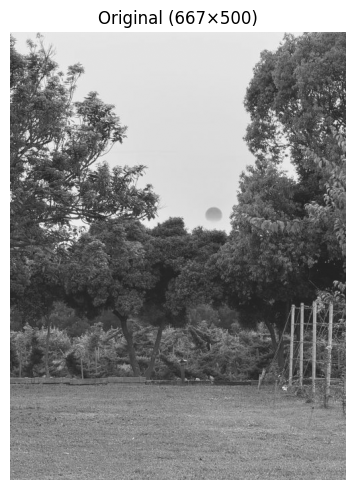

In [2]:
img_fn = "grassland.jpg"
X = load_grayscale(img_fn)
H, W = X.shape

# Show original
plt.figure(figsize=(5, 5))
plt.imshow(X, cmap="gray", vmin=0.0, vmax=1.0)
plt.title(f"Original ({H}×{W})")
plt.axis("off")
plt.tight_layout()

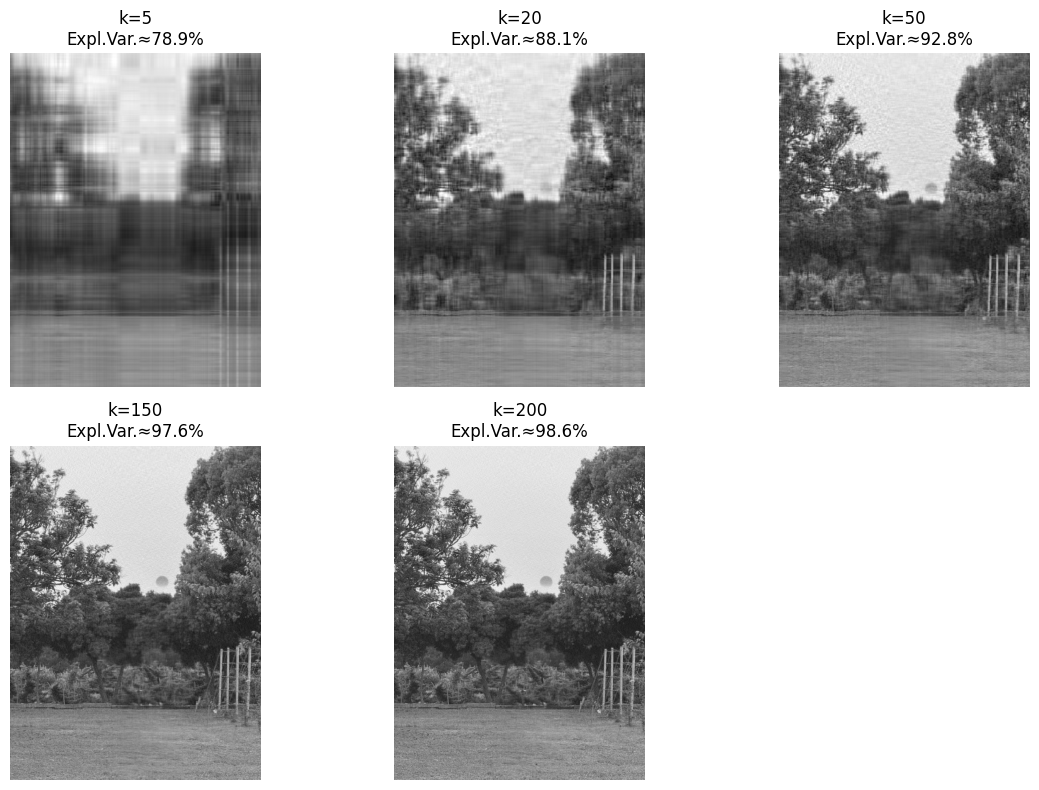

In [3]:
components = [5, 20, 50, 150, 200]

# Fit a full PCA once
pca = fit_full_pca(X, randomized=True)
X_pca = pca.transform(X)

# Sort and limit requested k's
k_list = sorted(set(k for k in components if 1 <= k <= min(H, W)))
if not k_list:
   raise ValueError(f"No valid k provided. Must be in [1, {min(H, W)}].")

# Create a grid: as many columns as reconstructions, one row
n = len(k_list)
cols = min(n, 3)
rows = (n + cols - 1) // cols
plt.figure(figsize=(4 * cols, 4 * rows))

for i, k in enumerate(k_list, start=1):
    Xk = reconstruct_from_transformed(X_pca, pca, k)
    plt.subplot(rows, cols, i)
    plt.imshow(Xk, cmap="gray", vmin=0.0, vmax=1.0)
    # Optionally show compression ratio-esque info:
    explained = pca.explained_variance_ratio_[:k].sum() * 100.0
    plt.title(f"k={k}\nExpl.Var.≈{explained:.1f}%")
    plt.axis("off")


plt.tight_layout()
plt.show()

### Sanity Check

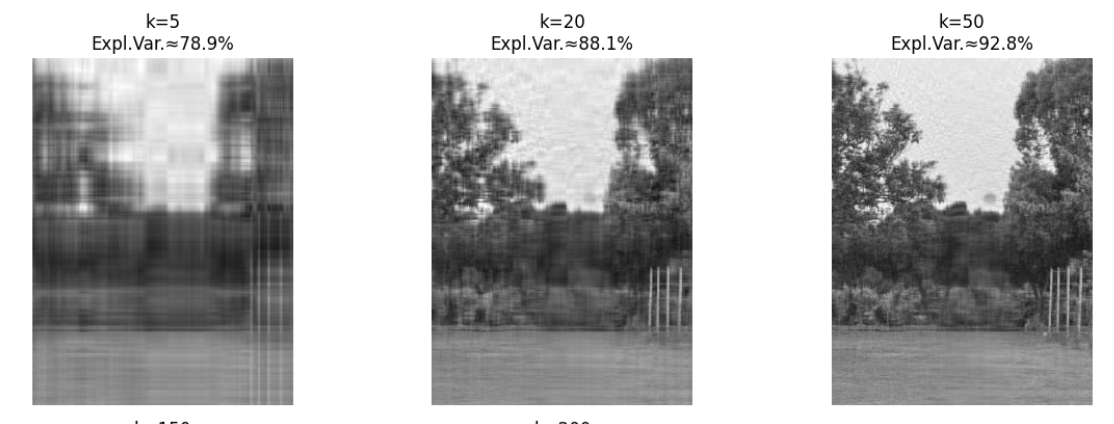

## Part 2: Chinese Character Embedding Visualization

In [4]:
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

本次練習使用的資料集為利用繁體中文新聞訓練的字元嵌入向量。每個中文字會對應到維度為100的向量。
嵌入向量使用Gensim套件訓練。由於嵌入向量的學習不是本次課程的主題，因此我們暫時略過一些細節，
只須知道每個中文字會對應到一個向量，而這個向量與這個字常出現的情境有關。例如，

"小貓是現代社會常見的寵物"

其中貓這個字可以替代為其他小動物，如"狗"。也就是說，

"小狗是現代社會常見的寵物"

這句話應該也會出現。因此貓跟狗有類似的意義，而這兩個字的嵌入向量應該類似。


由於原始資料有9405個中文字，這個數量在一些計算力較弱的電腦上可能會執行很久，
因此我們先將較不常出現的自移除。以加快執行速度。

In [5]:
with open('wordemb_100d.pickle', 'rb') as fh1:
    embed = pickle.load(fh1)
print(embed.keys())

dict_keys(['char', 'vec', 'count'])


In [6]:
print(f'There are {len(embed['char'])} characters')
print("The first ten characters are:", embed['char'][0:10])
print(f"The dimensions of the embedding matrix is: {embed['vec'].shape}")

There are 9405 characters
The first ten characters are: ['薹', '屼', '溏', '棰', '秦', '苾', '賈', '魎', '艱', '壘']
The dimensions of the embedding matrix is: (9405, 100)


In [7]:
count_vec = np.array(embed['count'])
char_vec = np.array(embed['char'])
# remove 60% of Chinese characters
threshold = np.quantile(count_vec, 0.6)
toinclude = count_vec > threshold

char_vec_sub = char_vec[toinclude]
vocab_list = list(char_vec_sub)
X = embed['vec']
X = X[toinclude]
print("The new shape is", X.shape)

The new shape is (3762, 100)


In [8]:
print("The first ten characters are:", vocab_list[0:10])
print("The last ten characters are:", vocab_list[-10:])

The first ten characters are: ['秦', '賈', '艱', '壘', '弈', '氰', '歉', '乃', '直', '遣']
The last ten characters are: ['蝕', '矮', '洗', '熄', '城', '休', '最', '冲', '挑', '臉']


### Plot the Overall Distribution Over Dimensions 0 and 1

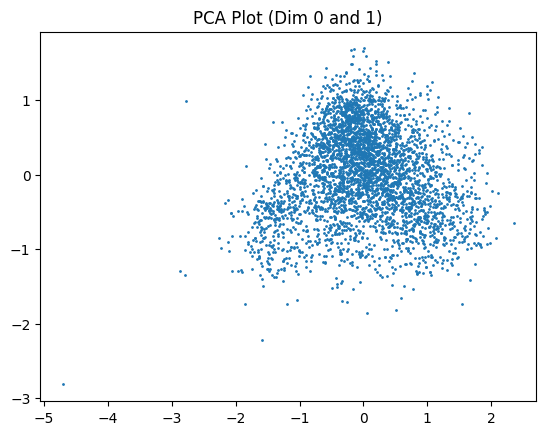

In [9]:
pca = PCA(n_components=4)
Bt = pca.fit(X).transform(X)

plt.figure(0)
plt.title("PCA Plot (Dim 0 and 1)")
plt.scatter(Bt[:, 0], Bt[:, 1], s=1)
plt.show()   

### Plot the Overall Distribution Over Dimensions 2 and 3

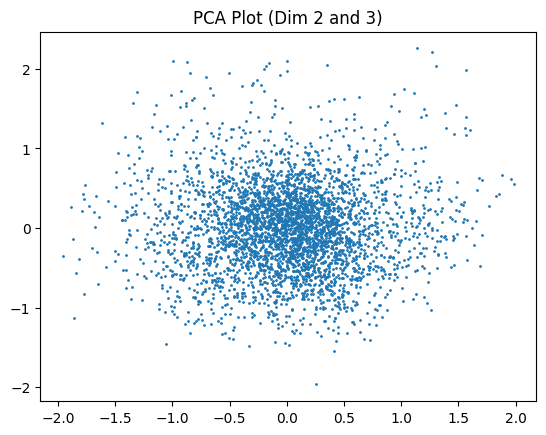

In [10]:
plt.figure(1)
plt.title("PCA Plot (Dim 2 and 3)")
plt.scatter(Bt[:, 2], Bt[:, 3], s=1)
plt.show()


### 細部結構觀察

字元數量太多，無法一一呈現。我們可以使用兩種方式來觀察細部的結構

1. 直接指定要觀察的範圍，例如 x_lim = [0.3, 0.5], y_lim = [1.1, 1.2]
2. 指定某個字做為中心，以及半寬(halfwd), 這時範圍是 x_lim = [x-halfwd, x+halfwd], y_lim = [y-halfwd, y+halfwd]



In [11]:
# subsetting method 1

def subset_by_limit(Bt, vocab, x_lim=[0, 0.1], y_lim=[0, 0.1]):
    # Bt is the stacked vector matrix,
    # vocab is the vocabulary list
    # x_lim the the x-axis range; y_lim the the y-axis range
    vocab = np.array(vocab)
    tmpind0 = (Bt[:, 0] >= x_lim[0]) * (Bt[:, 0] <= x_lim[1]) * (Bt[:, 1] >= y_lim[0]) * (Bt[:, 1] <= y_lim[1])
    return Bt[tmpind0], list(vocab[tmpind0])


def plot_detail(bsub, vsub, fontsize=12, marksize=1.5):
    from matplotlib import font_manager
    ChineseFont2 = font_manager.FontProperties()
    ChineseFont2.set_family('Heiti TC')
    ChineseFont2.set_size(fontsize)

    fig, ax = plt.subplots()
    ax.scatter(bsub[:, 0], bsub[:, 1], s=marksize)
    
    for i, txt in enumerate(vsub):
        ax.annotate(txt, (bsub[i][0],bsub[i][1]), fontsize = fontsize, fontproperties = ChineseFont2)


這裡我們看看在[0.1, 0.2]X[0.1, 0.2]區間的資料:

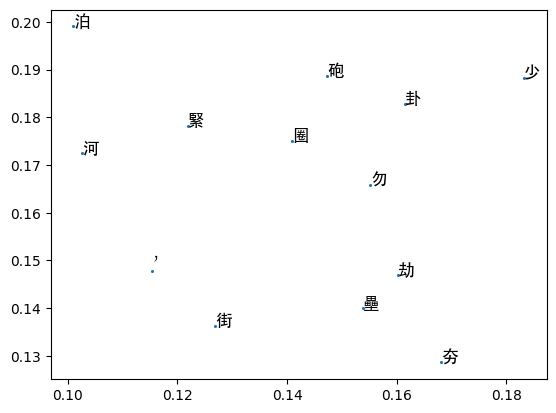

In [12]:
bsub, vsub = subset_by_limit(Bt, vocab_list, x_lim=[0.1, 0.2], y_lim=[0.1, 0.2])
plot_detail(bsub, vsub)

In [13]:
# subsetting method 2

def subset_by_centerc(Bt, vocab, centerc = '獸', halfwd = 0.1):
    # Bt is the stacked vector matrix,
    # vocab is the vocabulary list
    # centerc is the center-character
    # halfwd is the half width around the center
    
    vocab = np.array(vocab)
    seed_ind = vocab_list.index(centerc)
    seed_pos = Bt[seed_ind]
    
    tmpind0 = (Bt[:, 0] >= seed_pos[0]-halfwd) * (Bt[:, 0] <= seed_pos[0]+halfwd) * (Bt[:, 1] >= seed_pos[1]-halfwd) * (Bt[:, 1] <= seed_pos[1]+halfwd)
    return Bt[tmpind0], list(vocab[tmpind0])


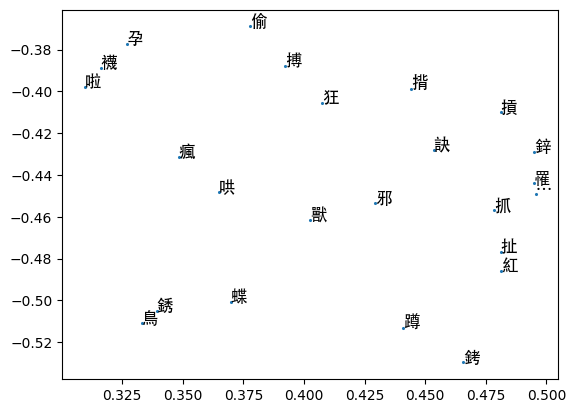

In [14]:
bsub, vsub = subset_by_centerc(Bt, vocab_list, centerc = '獸', halfwd = 0.1)
plot_detail(bsub, vsub)

### 畫出'賴'附近的字元

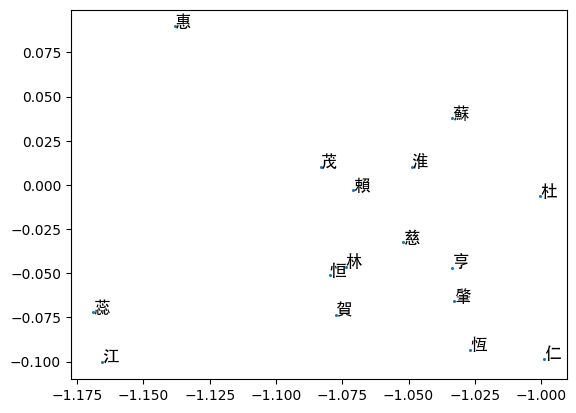

In [15]:
bsub, vsub = subset_by_centerc(Bt, vocab_list, centerc='賴', halfwd=0.1)
plot_detail(bsub, vsub)


### Sanity Check

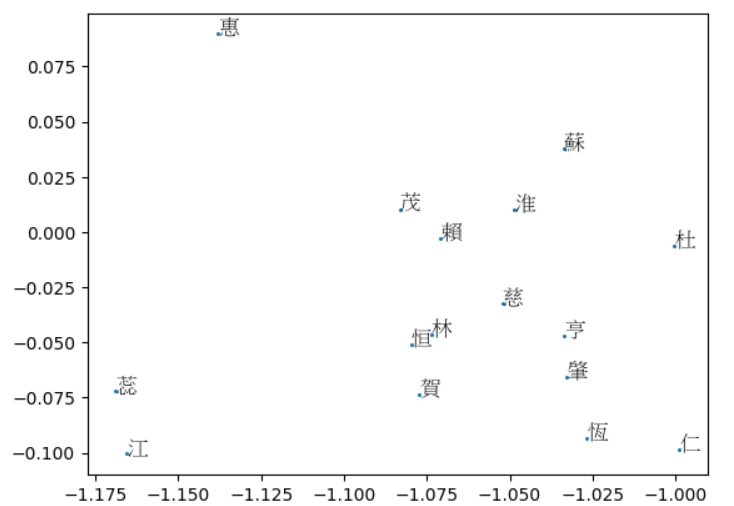

### TSNE

使用TSNE計算降維後的座標，並畫出整體分布

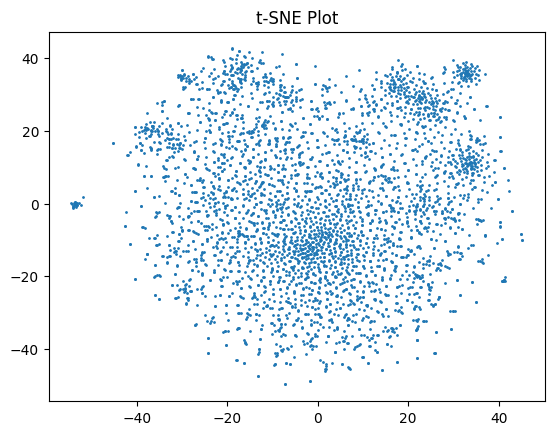

In [16]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', random_state=23)

Yt = tsne_model.fit_transform(X)

plt.figure(2)
plt.title("t-SNE Plot")
plt.scatter(Yt[:, 0], Yt[:, 1], s=1)
plt.show()


畫出'獸'附近的資料，設halfwd=3

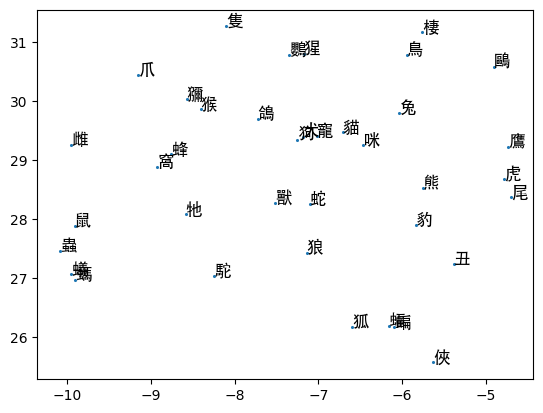

In [17]:
bsub, vsub = subset_by_centerc(Yt, vocab_list, centerc = '獸', halfwd = 3)
plot_detail(bsub, vsub)

## Plotting '賴' Neighborhood (halfwd=3)
畫出'賴'附近的資料，設halfwd=3


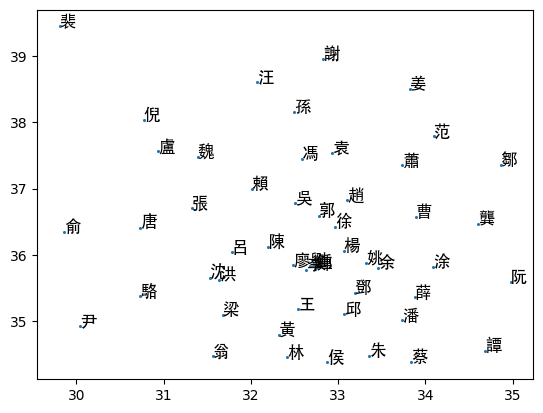

In [18]:
bsub, vsub = subset_by_centerc(Yt, vocab_list, centerc='賴', halfwd=3)
plot_detail(bsub, vsub)


### MDS

使用MDS計算降維後的座標，並畫出整體分布


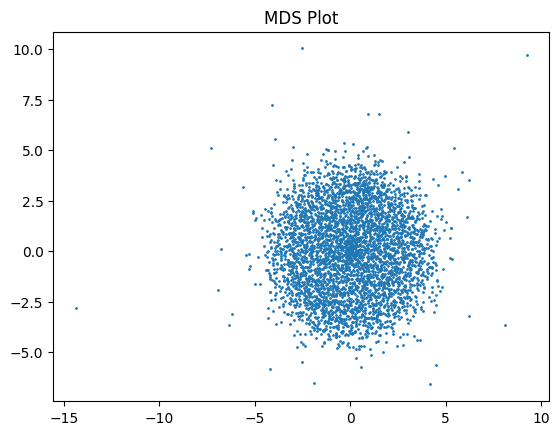

In [19]:
from sklearn.manifold import MDS

mds_model = MDS(n_components=2)
mds_x = mds_model.fit_transform(X)

plt.figure(3)
plt.title("MDS Plot")
plt.scatter(mds_x[:, 0], mds_x[:, 1], s=1)
plt.show()


畫出'獸'附近的資料，設halfwd=0.5

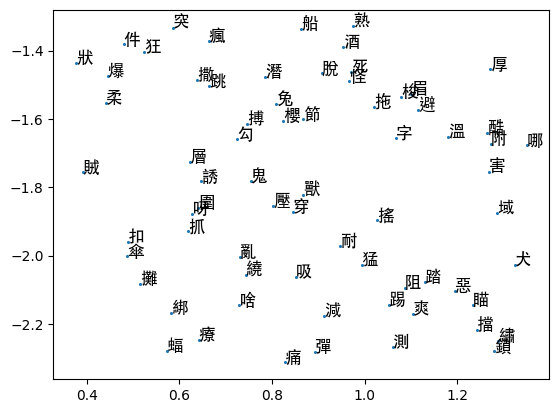

In [20]:
bsub, vsub = subset_by_centerc(mds_x, vocab_list, centerc = '獸', halfwd = 0.5)
plot_detail(bsub, vsub)

### Locally Linear Embedding

使用LLE計算降維後的座標，並畫出整體分布

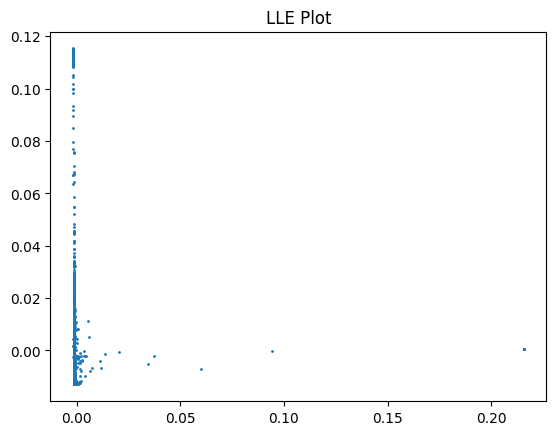

In [21]:
from sklearn.manifold import locally_linear_embedding
lle_x, _ = locally_linear_embedding(X,n_neighbors=10, n_components=2)

plt.figure(1)
plt.title("LLE Plot")
plt.scatter(lle_x[:, 0], lle_x[:, 1], s=1)
plt.show()   

畫出'獸'附近的資料，設halfwd=0.0001

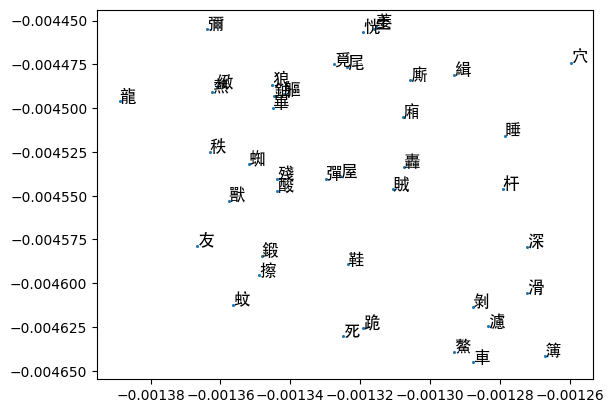

In [22]:
bsub, vsub = subset_by_centerc(lle_x, vocab_list, centerc = '獸', halfwd = 0.0001)
plot_detail(bsub, vsub)

### 比較PCA, t-SNE, MDS, LLE的Visualization 結果。你覺得哪個結果比較合理? 為什麼? 如何驗證?

t-SNE 最能聚出語義相近的字，局部結構保留最佳；PCA 僅線性投影，全域趨勢可看但細節鬆散；MDS 與 LLE 在此資料上易拉扯扭曲、難判讀。可用 kNN 一致性、語義分群、距離相關與超參數穩定性檢驗各自合理性。